In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ppfft.tools.new_fft import new_fft, new_ifft, new_fft2
from ppfft.tools.pad import pad, adj_pad
from ppfft.ppfft.ppfft import ppfft
from ppfft.inverse.onion_peeling import resample_row

# Selection of points in onion-peeling

We can try to find a pattern in the way points should be selected.

I we can't, we can precompute them (in the same way it is done for the Toeplitz matrices), since the indices only depend on $n$.

In [2]:
from ppfft.inverse.onion_peeling import find_closest

In [3]:
def build_y(k, n):
    """
    -(n//2) < k < 0
    """
    half_n = n // 2
    m = 2 * n + 1

    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)
    y_left = -4 * np.pi * np.arange(-half_n, k) / m
    y_right = 4 * np.pi * np.arange(-half_n, k) / m

    return np.concatenate((y_left, y_ppfft, y_right))

In [4]:
n = 10

for k in range(-(n // 2) + 1, 0):
    true_k = k + n // 2
    y = build_y(k, n)
    res = find_closest(y, n)
    print(res[true_k:-true_k] - true_k)

[ 0  1  2  4  5  6  8  9 10]
[ 0  2  3  5  7  8 10]
[ 0  2  5  8 10]
[ 0  5 10]


In [5]:
def new_find_closest(k, n):
    l = np.arange(k, -np.sign(k) - k, step=-np.sign(k))
    return n//2 + np.rint(- n * l / (2 * k)).astype(int)

In [6]:
for k in range(-(n // 2) + 1, 0):
    print(new_find_closest(k, n))

[ 0  1  3  4  5  6  7  9 10]
[ 0  2  3  5  7  8 10]
[ 0  3  5  7 10]
[ 0  5 10]


The behavior of the two methods is similar. The only difference is when a target point has two closest neighbors, in which case the previous method chooses the first one in the list, whereas the second method chooses the other. This should not have any influence on the onion-peeling method.

In [7]:
n = 1000
k = np.random.randint(-(n // 2) + 1, 0)
y = build_y(k, n)

In [8]:
%timeit find_closest(y, n)

11.6 ms ± 764 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit new_find_closest(k, n)

9.82 µs ± 297 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
n = 20
for k in range(-(n // 2) + 1, 0):
    print(np.max(np.abs(new_find_closest(k, n) - new_find_closest(-k, n))))

0
0
0
0
0
0
0
0
0


# Better initialization

$$
\forall k \in \llbracket - \frac{n}{2}, \frac{n}{2}\rrbracket, \, \widehat{I}_D(k, k) = \widehat{I}_v(2k, -\frac{n}{2}), 
\widehat{I}_D(k, -k) = \widehat{I}_h(2k, \frac{n}{2})

$$

In [11]:
def new_initialize(hori_ppfft, vert_ppfft):
    n = hori_ppfft.shape[0] - 1

    I_d = np.zeros(shape=(n + 1, n + 1), dtype=complex)

    I_d[0] = vert_ppfft[:, 0]  # x = -n/2
    I_d[-1] = vert_ppfft[::-1, -1]  # x = n/2
    I_d[:, 0] = hori_ppfft[:, 0]  # y = -n/2
    I_d[:, -1] = hori_ppfft[::-1, -1]  # y = n/2

    np.fill_diagonal(I_d, vert_ppfft[0, ::2])
    np.fill_diagonal(np.fliplr(I_d), vert_ppfft[-1, ::2])

    I_d[n // 2] = hori_ppfft[n // 2, ::2]
    I_d[:, n // 2] = vert_ppfft[n // 2, ::2]

    return I_d

In [12]:
def compute_true_Id(im):
    n = len(im)
    m = 2 * n + 1
    pad_im = pad(im, (m, m))
    return new_fft2(pad_im)[::2, ::2]

In [13]:
n = 100
im = np.random.rand(n, n)
hori, vert = ppfft(im)
true_Id = compute_true_Id(im)
init_Id = new_initialize(hori, vert)

/tmp/ipykernel_902040/4217498958.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(true_Id - init_Id)))


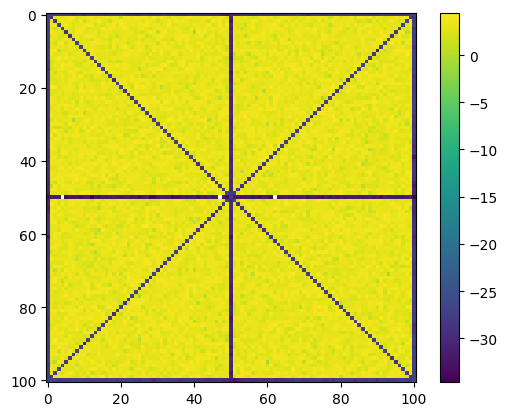

In [14]:
plt.imshow(np.log(np.abs(true_Id - init_Id)))
plt.colorbar()

Incorporate this is onion peeling, by not modifying these points.

In [15]:
from ppfft.resampling.fast_resampling import fast_compute_alpha

In [16]:
def fast_recover_row_negative(k, y, indices, vert_ppfft, Id):
    """
    Recovers row  -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, :true_k]

    known_I_D_neg = Id[true_k, -true_k:]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, true_k + 1 : n//2] = res[true_k + 1 : n//2]
    Id[true_k, n//2 + 1 : -true_k - 1] = res[n//2 + 1 : -true_k - 1]

    # Id[true_k, true_k:-true_k] = res[true_k:-true_k]


def fast_recover_row_positive(k, y, indices, vert_ppfft, Id):
    """
    Recovers row 0 < k < n//2 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, : (n - true_k)]

    known_I_D_neg = Id[true_k, (true_k - n) :]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, (n - true_k) + 1 : n//2] = res[(n - true_k) + 1 : n//2]
    Id[true_k, n//2 + 1 : true_k - n - 1] = res[n//2 + 1 : true_k - n - 1]

    # Id[true_k, (n - true_k) : (true_k - n)] = res[(n - true_k) : (true_k - n)]


def fast_recover_col_negative(k, y, indices, hori_ppfft, Id):
    """
    Recovers column -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[:true_k, true_k]

    known_I_D_neg = Id[-true_k:, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k + 1 : n//2, true_k] = res[true_k + 1 : n//2]
    Id[n//2 + 1 : -true_k - 1, true_k] = res[n//2 + 1 : -true_k - 1]

    # Id[true_k:-true_k, true_k] = res[true_k:-true_k]


def fast_recover_col_positive(k, y, indices, hori_ppfft, Id):
    """
    Recovers column 0 < k < n//2 Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[: (n - true_k), true_k]

    known_I_D_neg = Id[(true_k - n) :, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[(n - true_k) + 1 : n//2, true_k] = res[(n - true_k) + 1 : n//2]
    Id[n//2 + 1 : true_k - n - 1, true_k] = res[n//2 + 1 : true_k - n - 1]

    # Id[(n - true_k) : (true_k - n), true_k] = res[(n - true_k) : (true_k - n)]



In [17]:
def fast_onion_peeling(hori_ppfft, vert_ppfft):
    Id = new_initialize(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[0] - 1
    m = 2 * n + 1
    half_n = n // 2

    for k in range(-(n // 2) + 1, 0):

        y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)
        indices = new_find_closest(k, n)
        y_ppfft = np.take(y_ppfft, indices)

        y_pos = -4 * np.pi * np.arange(-half_n, k) / m
        y_neg = 4 * np.pi * np.arange(-half_n, k)[::-1] / m

        y = np.concatenate((y_pos, y_ppfft, y_neg))

        fast_recover_row_negative(k, y, indices, vert_ppfft, Id)
        fast_recover_row_positive(-k, y, indices, vert_ppfft, Id)

        fast_recover_col_negative(k, y, indices, hori_ppfft, Id)
        fast_recover_col_positive(-k, y, indices, hori_ppfft, Id)

    return Id

In [18]:
im = plt.imread("Shepp_logan_240.png")
hori, vert = ppfft(im)
true_Id = compute_true_Id(im)

In [19]:
res = fast_onion_peeling(hori, vert)

/tmp/ipykernel_902040/1056498047.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(true_Id - res)))


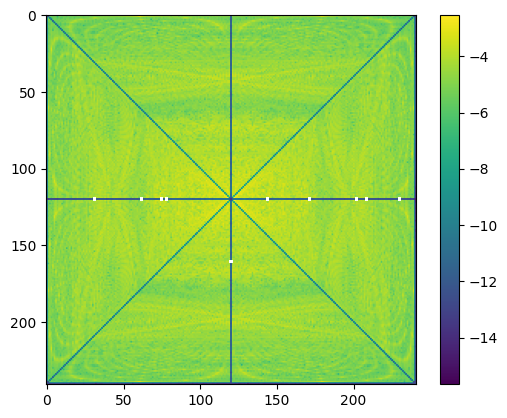

In [20]:
plt.imshow(np.log10(np.abs(true_Id - res)))
plt.colorbar()

# Precomputations

In [21]:
from scipy.linalg import solve_toeplitz, matmul_toeplitz

from pynufft import NUFFT

In [22]:
class InverseToeplitz:

    def __init__(self, col, row=None) -> None:
        """
        A Toeplitz matrix T is represented by:
        - its first column: col
        - its first row: row

        If row is not provided, it is assumed T is Hermitian.
        """
        self.col = col
        self.row = row

        self.x0 = None
        self.m1 = None
        self.m2 = None
        self.m3 = None
        self.m4 = None

        self.gohberg_semencul()

    def gohberg_semencul(self):
        """
        Compute the Gohberg-Semencul decomposition of T^{-1}
        """
        e0 = np.zeros_like(self.col)
        e0[0] = 1

        e1 = np.zeros_like(self.col)
        e1[-1] = 1

        if self.row is None:
            x = solve_toeplitz(self.col, e0)
            y = solve_toeplitz(self.col, e1)

        else:
            x = solve_toeplitz((self.col, self.row), e0)
            y = solve_toeplitz((self.col, self.row), e1)

        x_a = np.zeros_like(x)
        x_a[0] = x[0]

        x_b = np.zeros_like(x)
        x_b[1::] = x[:0:-1]

        y_a = np.zeros_like(y)
        y_a[0] = y[-1]

        y_b = np.zeros_like(y)
        y_b[1::] = y[:-1]

        self.x0 = x[0]
        self.m1 = (x, x_a)
        self.m2 = (y_a, y[::-1])
        self.m3 = (y_b, np.zeros_like(y))
        self.m4 = (np.zeros_like(x), x_b)

    def apply_inverse(self, vec):
        """
        Computes T^{-1} @ vec.
        """
        M1M2_v = matmul_toeplitz(self.m1, matmul_toeplitz(self.m2, vec))

        M3M4_v = matmul_toeplitz(self.m3, matmul_toeplitz(self.m4, vec))

        return (M1M2_v - M3M4_v) / self.x0
        

In [23]:
def precompute_onion_peeling(n):
    """
    Computes and stores:
    - all the Toeplitz inverses 
    - all the Nufft objects
    needed for the onion-peeling algorithm.
    """

    half_n = n // 2
    m = 2 * n + 1

    toeplitz_list = []
    nufft_list = []
    
    for k in range(-half_n + 1, 0):

        y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)
        indices = new_find_closest(k, n)
        y_ppfft = np.take(y_ppfft, indices)

        y_pos = -4 * np.pi * np.arange(-half_n, k) / m
        y_neg = 4 * np.pi * np.arange(-half_n, k)[::-1] / m

        y = np.concatenate((y_pos, y_ppfft, y_neg))

        c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))

        toeplitz_list.append(InverseToeplitz(col=c))

        NufftObj = NUFFT()
        NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(2 * n,), Jd=(6,))
        nufft_list.append(NufftObj)

    return toeplitz_list, nufft_list


In [24]:
def ultimate_recover_row_negative(k, indices, vert_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers row  -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, :true_k]

    known_I_D_neg = Id[true_k, -true_k:]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[true_k, true_k + 1 : n//2] = res[true_k + 1 : n//2]
    Id[true_k, n//2 + 1 : -true_k - 1] = res[n//2 + 1 : -true_k - 1]


def ultimate_recover_row_positive(k, indices, vert_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers row 0 < k < n//2 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, : (n - true_k)]

    known_I_D_neg = Id[true_k, (true_k - n) :]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[true_k, (n - true_k) + 1 : n//2] = res[(n - true_k) + 1 : n//2]
    Id[true_k, n//2 + 1 : true_k - n - 1] = res[n//2 + 1 : true_k - n - 1]


def ultimate_recover_col_negative(k, indices, hori_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers column -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[:true_k, true_k]

    known_I_D_neg = Id[-true_k:, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[true_k + 1 : n//2, true_k] = res[true_k + 1 : n//2]
    Id[n//2 + 1 : -true_k - 1, true_k] = res[n//2 + 1 : -true_k - 1]


def ultimate_recover_col_positive(k, indices, hori_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers column 0 < k < n//2 Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[: (n - true_k), true_k]

    known_I_D_neg = Id[(true_k - n) :, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[(n - true_k) + 1 : n//2, true_k] = res[(n - true_k) + 1 : n//2]
    Id[n//2 + 1 : true_k - n - 1, true_k] = res[n//2 + 1 : true_k - n - 1]

In [25]:
def ultimate_onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    Id = new_initialize(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2

    for toeplitz_inv, NufftObj, k in zip(toeplitz_list, nufft_list, range(-half_n + 1, 0)):

        indices = new_find_closest(k, n) # we could precompute this

        ultimate_recover_row_negative(k, indices, vert_ppfft, Id, toeplitz_inv, NufftObj)
        ultimate_recover_row_positive(-k, indices, vert_ppfft, Id, toeplitz_inv, NufftObj)

        ultimate_recover_col_negative(k, indices, hori_ppfft, Id, toeplitz_inv, NufftObj)
        ultimate_recover_col_positive(-k, indices, hori_ppfft, Id, toeplitz_inv, NufftObj)

    return Id

In [26]:
im = plt.imread("Shepp_logan_240.png")
hori, vert = ppfft(im)
true_Id = compute_true_Id(im)

In [27]:
toeplitz_list, nufft_list = precompute_onion_peeling(im.shape[0])

In [28]:
res = ultimate_onion_peeling(hori, vert, toeplitz_list, nufft_list)

/tmp/ipykernel_902040/1056498047.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(true_Id - res)))


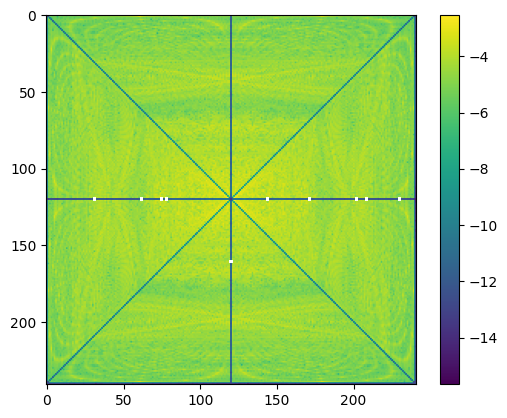

In [29]:
plt.imshow(np.log10(np.abs(true_Id - res)))
plt.colorbar()

In [30]:
%timeit ultimate_onion_peeling(hori, vert, toeplitz_list, nufft_list)

339 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit fast_onion_peeling(hori, vert)

8.38 s ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Another improvement of onion-peeling

During the onion-peeling process, we actually compute:
$$
\forall v \in \mathcal{D}(n), \, \sum_{u \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{2ku}{m} \right) = \mathcal{F}_D(I(:, v))(k)
$$

when recovering row $k$.

In [32]:
from ppfft.inverse.fast_direct_inverse import precompute_all, adj_F_D, InverseToeplitz, fast_direct_inversion
from ppfft.ppfft.ppfft import ppfft
from ppfft.inverse.fast_onion_peeling import fast_initialize, new_find_closest

In [33]:
def new_ultimate_recover_row_negative(k, indices, vert_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers row  -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, :true_k]

    known_I_D_neg = Id[true_k, -true_k:]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[true_k, true_k + 1 : n//2] = res[true_k + 1 : n//2]
    Id[true_k, n//2 + 1 : -true_k - 1] = res[n//2 + 1 : -true_k - 1]

    return alpha


def new_ultimate_recover_row_positive(k, indices, vert_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers row 0 < k < n//2 of Id.
    Id is modified in place.
    """
    n = vert_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[true_k, : (n - true_k)]

    known_I_D_neg = Id[true_k, (true_k - n) :]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[true_k, (n - true_k) + 1 : n//2] = res[(n - true_k) + 1 : n//2]
    Id[true_k, n//2 + 1 : true_k - n - 1] = res[n//2 + 1 : true_k - n - 1]

    return alpha


def new_ultimate_recover_col_negative(k, indices, hori_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers column -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[:true_k, true_k]

    known_I_D_neg = Id[-true_k:, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft, known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[true_k + 1 : n//2, true_k] = res[true_k + 1 : n//2]
    Id[n//2 + 1 : -true_k - 1, true_k] = res[n//2 + 1 : -true_k - 1]

    return alpha


def new_ultimate_recover_col_positive(k, indices, hori_ppfft, Id, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    Recovers column 0 < k < n//2 Id.
    Id is modified in place.
    """
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    known_ppfft = np.take(known_ppfft, indices)

    known_I_D_pos = Id[: (n - true_k), true_k]

    known_I_D_neg = Id[(true_k - n) :, true_k]

    known_samples = np.concatenate((known_I_D_pos, known_ppfft[::-1], known_I_D_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(known_samples))

    res = resample_row(alpha)

    Id[(n - true_k) + 1 : n//2, true_k] = res[(n - true_k) + 1 : n//2]
    Id[n//2 + 1 : true_k - n - 1, true_k] = res[n//2 + 1 : true_k - n - 1]

    return alpha

In [34]:
def new_ultimate_onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list, toeplitz):
    Id = fast_initialize(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[0] - 1
    half_n = n // 2

    all_alpha = np.zeros(shape=(n + 1, n), dtype=complex) # indexed (k, v)

    all_alpha[0, :] = toeplitz.apply_inverse(adj_F_D(Id[0, :]))
    all_alpha[n//2, :] = toeplitz.apply_inverse(adj_F_D(Id[n//2, :]))
    all_alpha[n, :] = toeplitz.apply_inverse(adj_F_D(Id[n, :]))

    for toeplitz_inv, NufftObj, k in zip(toeplitz_list, nufft_list, range(-half_n + 1, 0)):

        indices = new_find_closest(k, n) # we could precompute this

        all_alpha[k + half_n, :] = new_ultimate_recover_row_negative(k, indices, vert_ppfft, Id, toeplitz_inv, NufftObj)
        all_alpha[-(k + half_n) - 1, :] = new_ultimate_recover_row_positive(-k, indices, vert_ppfft, Id, toeplitz_inv, NufftObj)

        new_ultimate_recover_col_negative(k, indices, hori_ppfft, Id, toeplitz_inv, NufftObj)
        new_ultimate_recover_col_positive(-k, indices, hori_ppfft, Id, toeplitz_inv, NufftObj)

    return all_alpha

In [35]:
def test_(im):
    n = len(im)
    m = 2 * n + 1
    u = np.arange(-(n//2), n//2)
    k = np.arange(-(n//2), n//2 + 1)
    ku = k[:, None] * u[None, :]

    return np.einsum("uv,ku->kv", im, np.exp(-2j * np.pi * 2 * ku / m))

In [36]:
n = 100
toeplitz_list, nufft_list, toeplitz = precompute_all(n)

im = np.random.rand(n, n)
hori, vert = ppfft(im)

alpha = new_ultimate_onion_peeling(hori, vert, toeplitz_list, nufft_list, toeplitz)

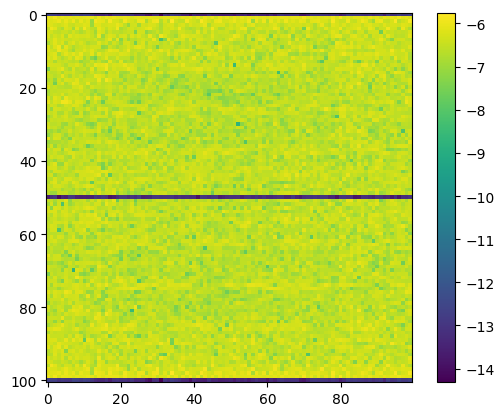

In [37]:
plt.imshow(np.log10(np.abs(alpha - test_(im))))
plt.colorbar()

In [38]:
def invert_alpha(alpha, toeplitz):
    n = np.shape(alpha)[1]
    res = np.zeros(shape=(n, n), dtype=complex)

    for k, col in enumerate(alpha.T):
        res[:, k] = toeplitz.apply_inverse(adj_F_D(col))

    return res


In [39]:
im = plt.imread("Shepp_logan_240.png")
hori, vert = ppfft(im)

In [40]:
toeplitz_list, nufft_list, toeplitz = precompute_all(im.shape[0])

In [41]:
sol_fast_direct_inversion = fast_direct_inversion(hori, vert, (toeplitz_list, nufft_list, toeplitz))

In [42]:
alpha = new_ultimate_onion_peeling(hori, vert, toeplitz_list, nufft_list, toeplitz)
sol_new = invert_alpha(alpha, toeplitz)

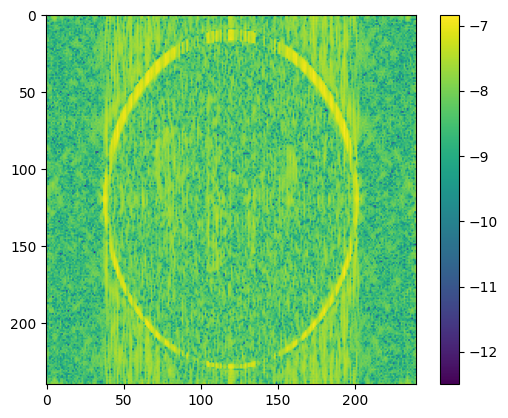

In [43]:
plt.imshow(np.log10(np.abs(sol_new.real - im)))
plt.colorbar()

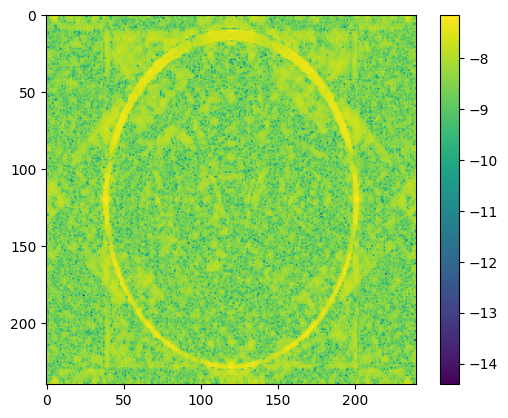

In [44]:
plt.imshow(np.log10(np.abs(sol_fast_direct_inversion.real - im)))
plt.colorbar()